Does the amplitude of the TESS light curve change over time?

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
import astropy.units as u
import astropy.constants as const
from astropy.modeling import models, fitting
import lightkurve as lk
from astropy.coordinates import SkyCoord
from matplotlib.gridspec import GridSpec
from datetime import datetime

#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

In [3]:
path20 = '/media/david/5tb_storage1/cc_cet/tess/MAST_2021-01-01T1635/TESS/tess2020294194027-s0031-0000000337219837-0198-a_fast/'
lcpath20 = glob.glob('{}*lc.fits'.format(path20))[0]
lcpath20

'/media/david/5tb_storage1/cc_cet/tess/MAST_2021-01-01T1635/TESS/tess2020294194027-s0031-0000000337219837-0198-a_fast/tess2020294194027-s0031-0000000337219837-0198-a_fast-lc.fits'

In [4]:
data20 = fits.getdata(lcpath20,1)
t, f, e, q, bk = data20['TIME'], data20['PDCSAP_FLUX'], data20['PDCSAP_FLUX_ERR'], data20['QUALITY'], data20['SAP_BKG']#[np.isnan(data['SAP_BKG'])==False]
t, f, e, bk = t[q==0], f[q==0], e[q==0], bk[q==0]
lc20 = lk.LightCurve(time=t, flux=f, flux_err=e ).remove_nans()#.remove_outliers(sigma=5)

<AxesSubplot:xlabel='Time [JD]', ylabel='Normalized Flux'>

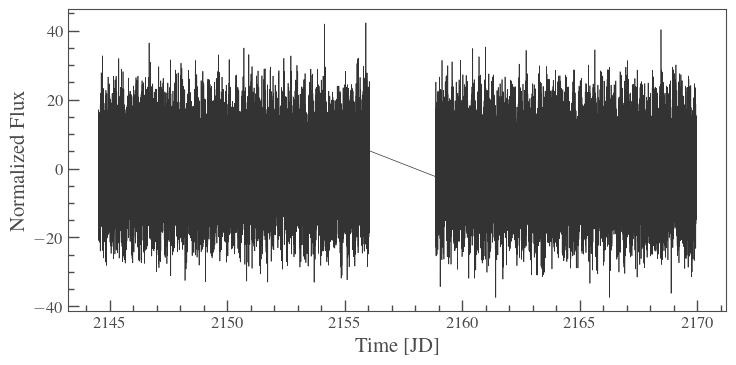

In [50]:
lc20n = lc20.normalize(unit='percent')
lc20n.flux -=100*u.percent
lc20n.plot()

0.28665746631447636 d


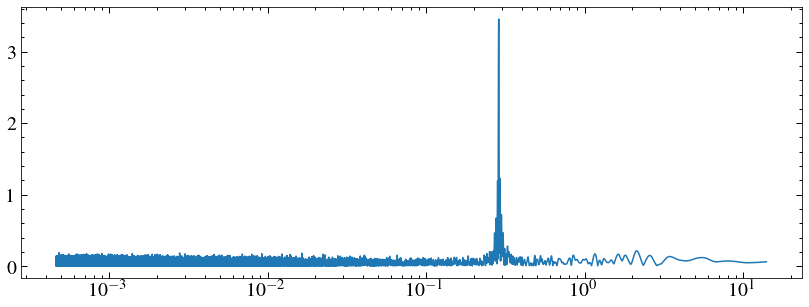

In [42]:
pg20n = lc20n.to_periodogram(oversample_factor=10,minimum_period=40*u.second, maximum_period=14*u.day)
plt.plot(pg20n.period, pg20n.power)
plt.xscale('log')
print(pg20n.period_at_max_power)

In [97]:
lc20f = lc20n.fold(pg20n.period_at_max_power, normalize_phase=True)


In [105]:
lc20f= lc20f.bin(bins=10)
lc20f.errorbar()

TypeError: bin() got an unexpected keyword argument 'bins'

In [43]:
import math as mt
daylist = [mt.floor(ti) for ti in lc20n.time.value]
days = np.unique(daylist)
days

array([2144, 2145, 2146, 2147, 2148, 2149, 2150, 2151, 2152, 2153, 2154,
       2155, 2156, 2158, 2159, 2160, 2161, 2162, 2163, 2164, 2165, 2166,
       2167, 2168, 2169])

In [44]:
#cut out the gap
mask = (days > 2144) & (days <2156)| (days >2158) & (days < 2169)
days = days[mask]
days

array([2145, 2146, 2147, 2148, 2149, 2150, 2151, 2152, 2153, 2154, 2155,
       2159, 2160, 2161, 2162, 2163, 2164, 2165, 2166, 2167, 2168])

3.6457573069741906 %
0.2856737291986289 d


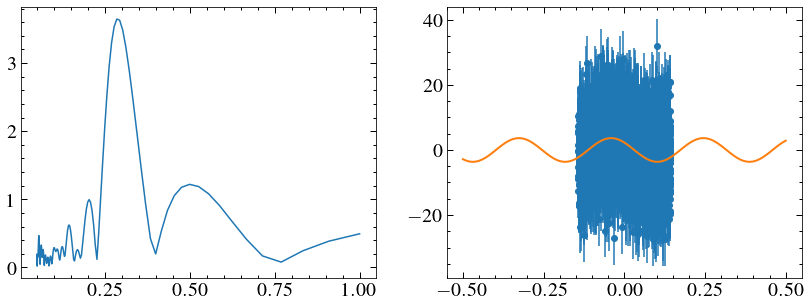

3.3277020264749613 %
0.28562577876138484 d


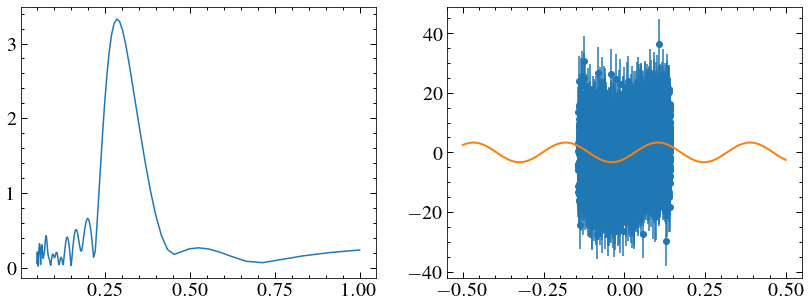

3.4703476492454737 %
0.28567245779863504 d


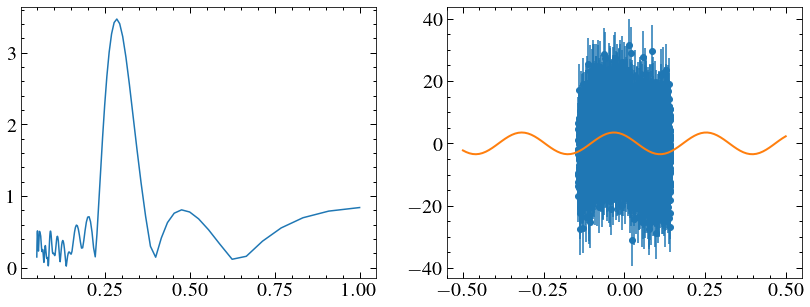

3.373519133253314 %
0.2856719491241156 d


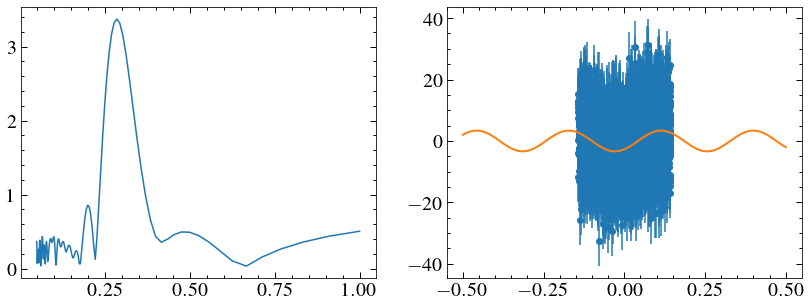

3.4254709414004227 %
0.28567147580470614 d


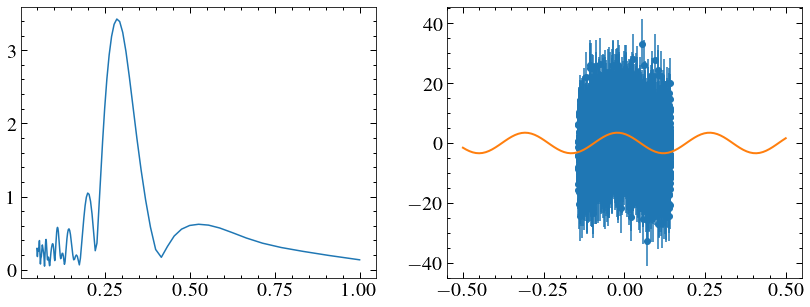

3.6696854322488623 %
0.285671024250215 d


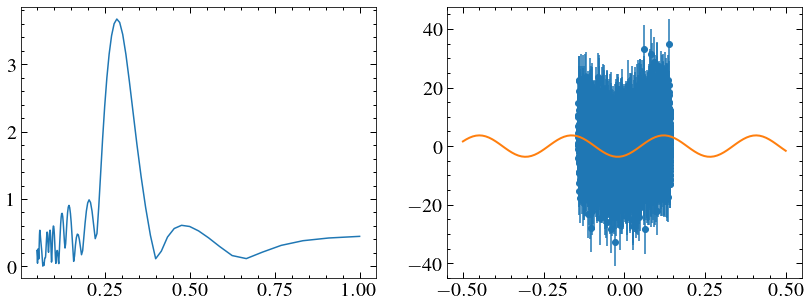

3.4416838494529722 %
0.2856705870463228 d


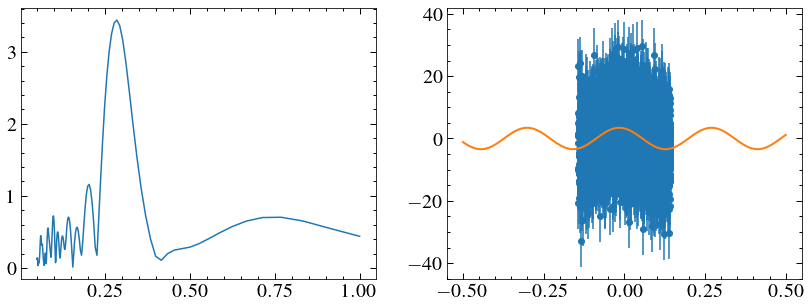

3.4831933753261812 %
0.29407275853139353 d


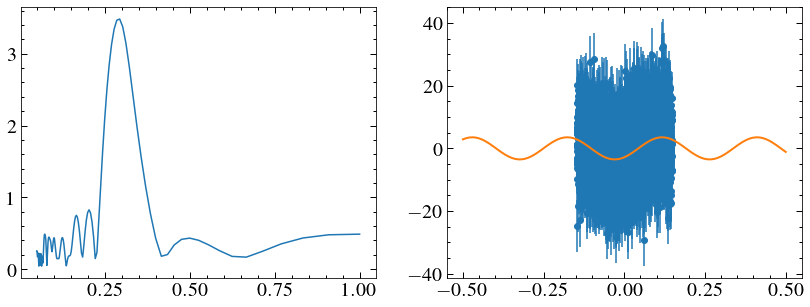

3.3894295742840193 %
0.285669744667949 d


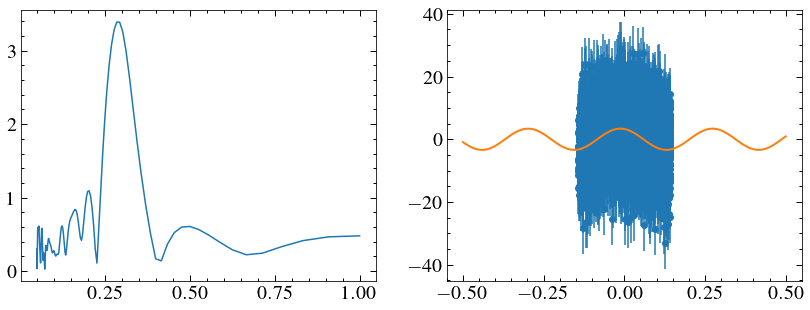

3.3853071336564327 %
0.2856693435798234 d


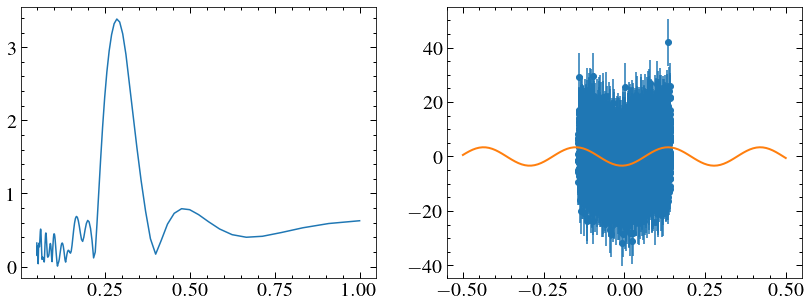

4.005697069418732 %
0.29407155291285375 d


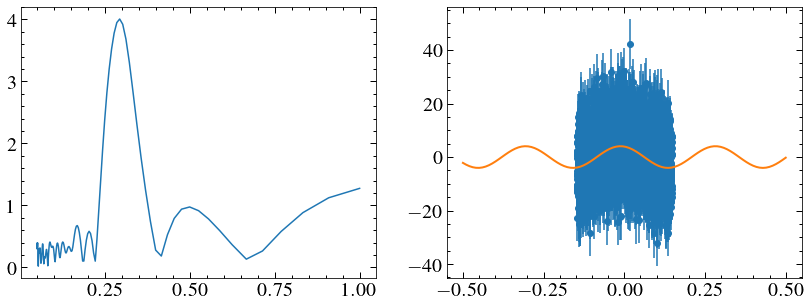

3.601755370955086 %
0.2940236833863503 d


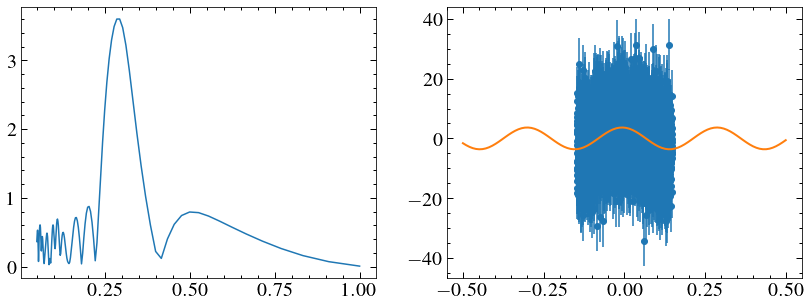

3.8169753022915227 %
0.27773265077581155 d


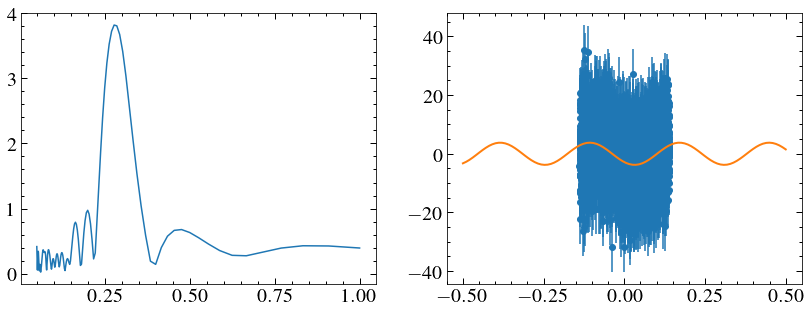

3.4932735212254538 %
0.28562050044491827 d


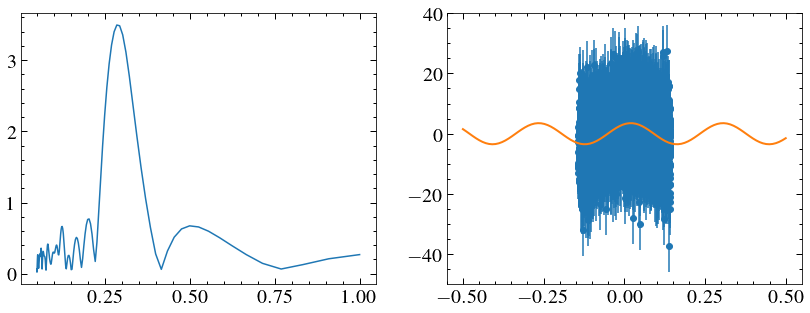

3.3112127799614397 %
0.2940697513953939 d


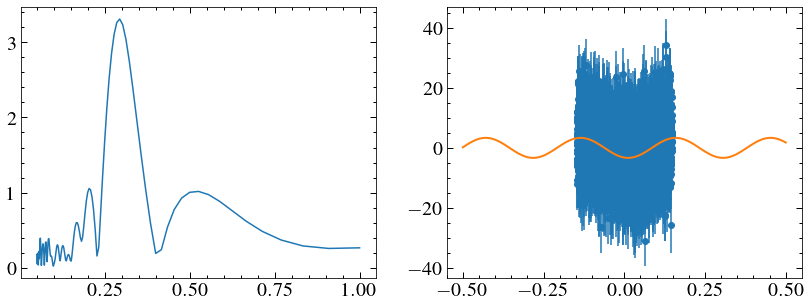

3.3010909612583563 %
0.28571394712251885 d


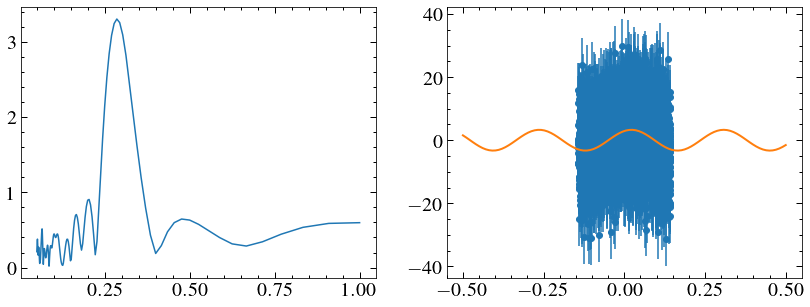

3.6511274829731386 %
0.28566622829290267 d


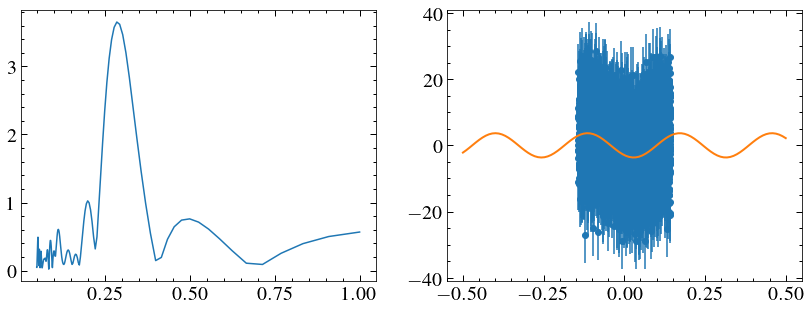

3.119444347084068 %
0.28566577150416406 d


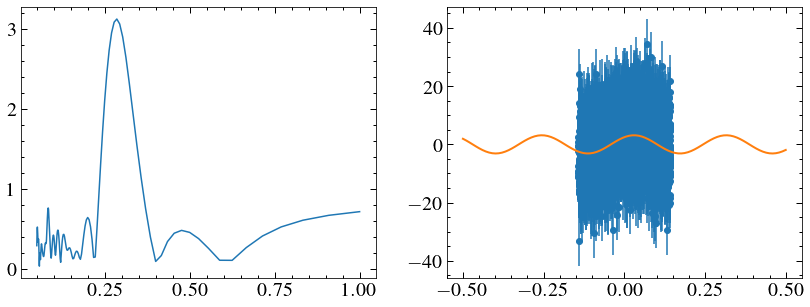

3.601301145290767 %
0.2940678413758112 d


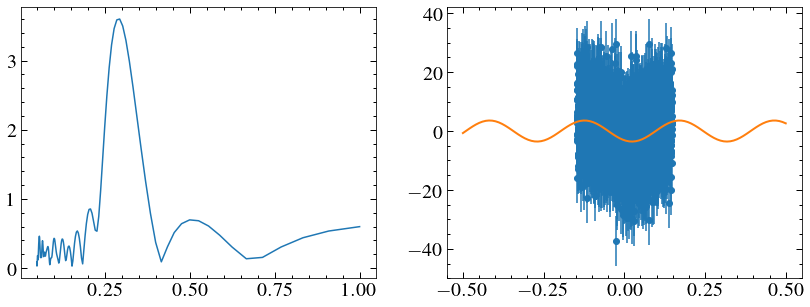

3.335060854879477 %
0.2856648929013295 d


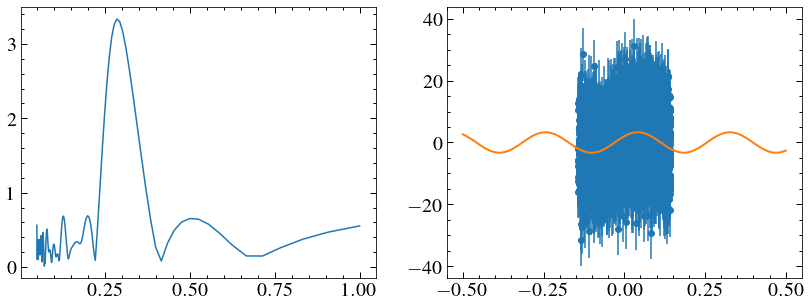

3.050769193246699 %
0.28566446909153487 d


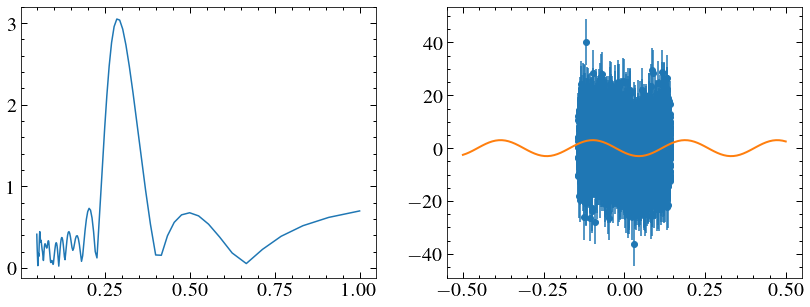

In [90]:
fitter = fitting.LevMarLSQFitter()

amplitudes = []
amp_errors = []




for day in days:
    mask = (daylist == day)
    lcd = lk.LightCurve(time=lc20n.time[mask], flux=lc20n.flux[mask], flux_err=lc20n.flux_err[mask] )
    pgd = lcd.to_periodogram(oversample_factor=10,minimum_period=0.05*u.day, maximum_period=1*u.day)
    print(pgd.max_power)
    print(pgd.period_at_max_power)

    plt.subplot(121)
    plt.plot(pgd.period, pgd.power)
    lcdf = lcd.fold(pgd.period_at_max_power)#.bin(0.01)
    plt.subplot(122)
   # print(lcdf.time)
    plt.errorbar(lcdf.time.value, lcdf.flux.value, yerr=lcdf.flux_err.value, marker='o', ls='none')
    fold_mod =  models.Sine1D(amplitude=pgd.max_power.value, frequency= 1/pgd.period_at_max_power.value, phase=0, fixed={'frequency':True})
    fold_fit = fitter(fold_mod, lcdf.time.value, lcdf.flux.value, weights = 1/lcdf.flux_err.value, maxiter=10000)
    fold_fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))
    fold_time = np.linspace(-0.5, 0.5, 100)
    plt.plot(fold_time, fold_fit(fold_time), c='C1', lw=2, zorder=10)
    plt.show()
    amplitudes.append(abs(fold_fit.amplitude.value))
    amp_errors.append(fold_fit_e[0])
   # lcd.scatter()
    #plt.show()

<ErrorbarContainer object of 3 artists>

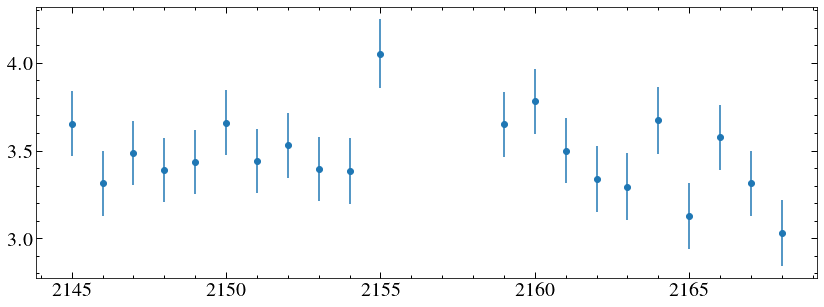

In [91]:
plt.errorbar(days, amplitudes, yerr=amp_errors, marker='o', ls='none')

(array([2., 0., 3., 5., 4., 1., 4., 1., 0., 1.]),
 array([3.0279888 , 3.13044986, 3.23291092, 3.33537198, 3.43783304,
        3.5402941 , 3.64275516, 3.74521622, 3.84767728, 3.95013834,
        4.0525994 ]),
 <BarContainer object of 10 artists>)

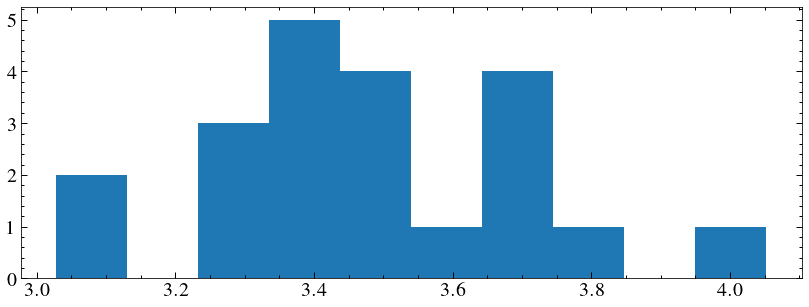

In [106]:
plt.hist(amplitudes)

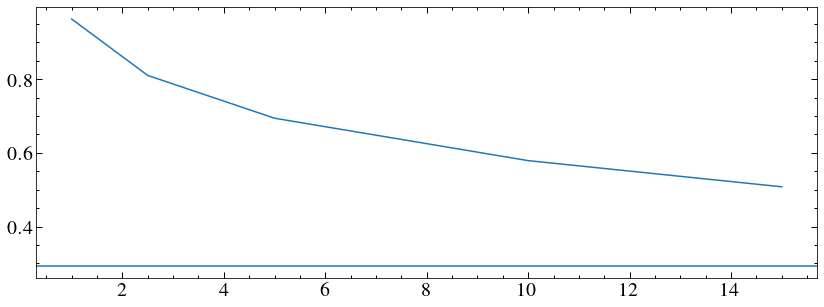

In [107]:
from scipy.stats import anderson
ad = anderson(amplitudes)
plt.plot(ad.significance_level, ad.critical_values)
plt.axhline(ad.statistic)

2144.519617308289
3.3826663149727207 %
0.27759918231881925 d


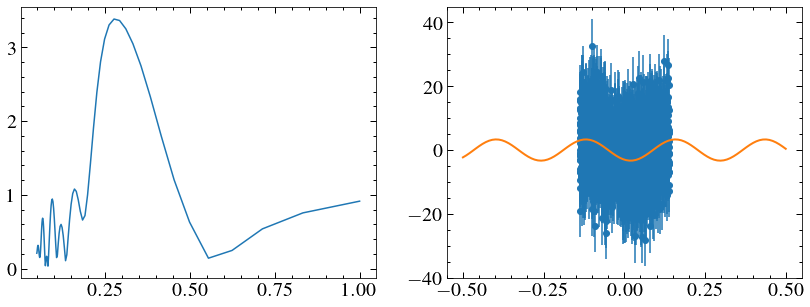

2145.019617308289
3.5442853180222613 %
0.29402850571160905 d


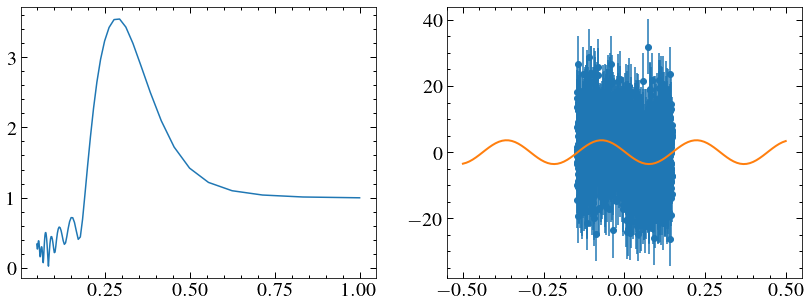

2145.519617308289
3.757688215011927 %
0.2938357616371791 d


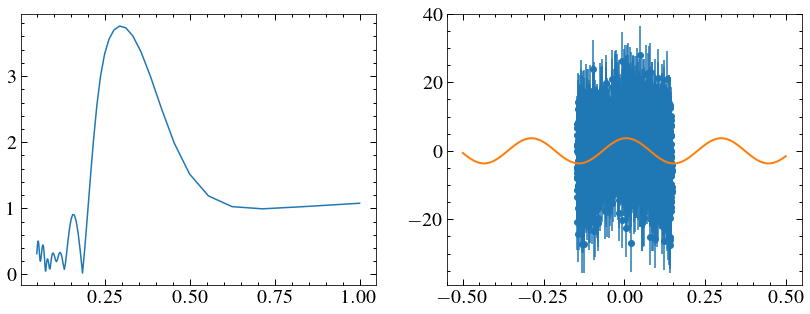

2146.019617308289
3.22037145309049 %
0.27769091297293624 d


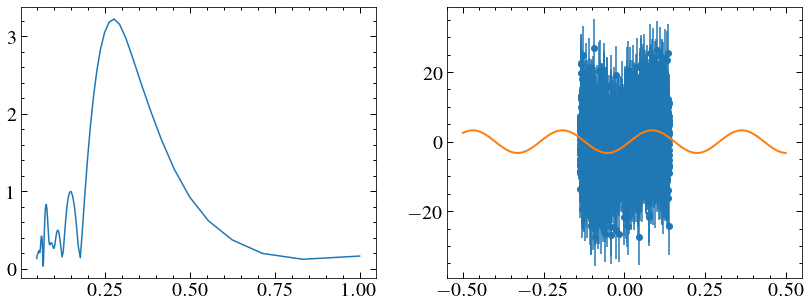

2146.519617308289
3.467088692378296 %
0.27769061022088887 d


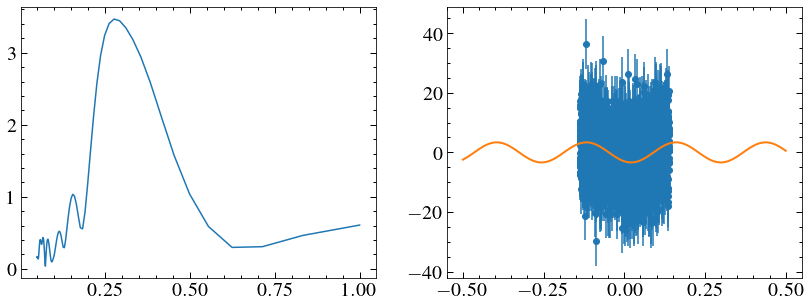

2147.019617308289
3.439236629504612 %
0.277690331763046 d


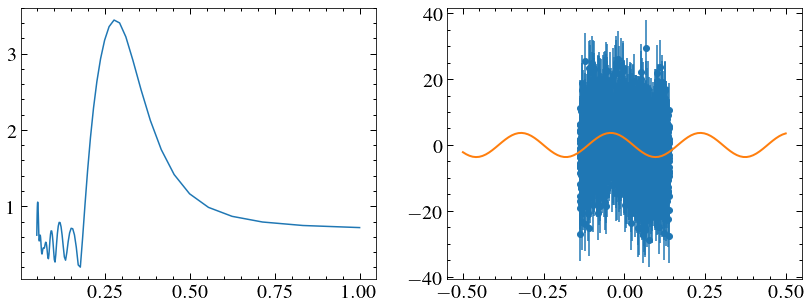

2147.519617308289
3.555557469595214 %
0.29402688073883654 d


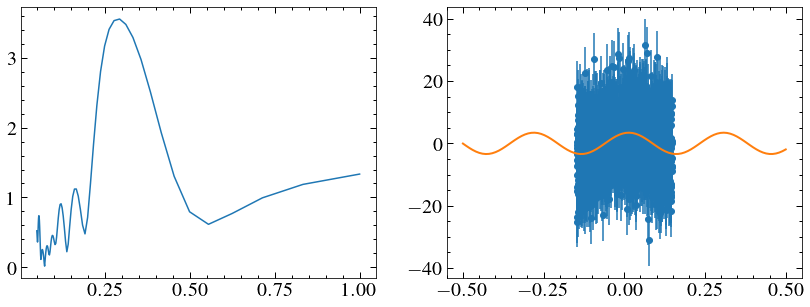

2148.019617308289
3.4547155389305435 %
0.2940266231255085 d


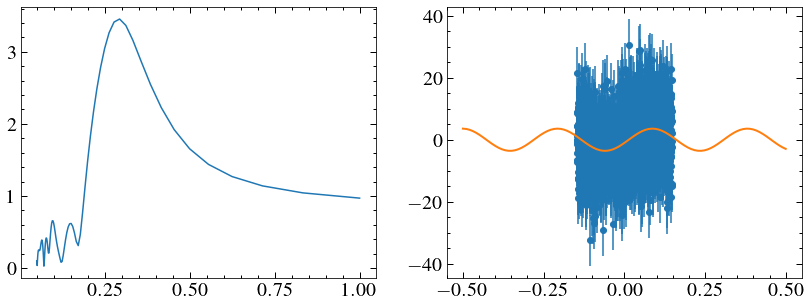

2148.519617308289
3.27059065802401 %
0.27768958216975076 d


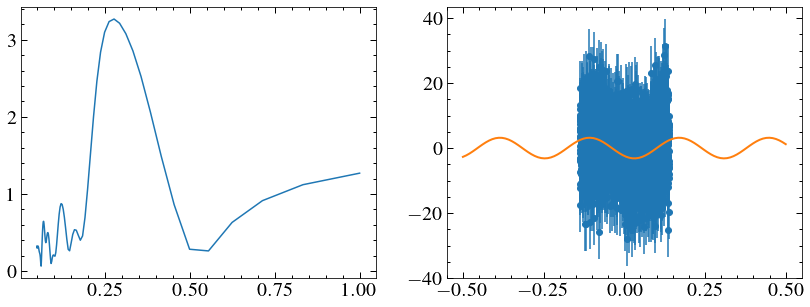

2149.019617308289
3.4763989326776272 %
0.2776893502460706 d


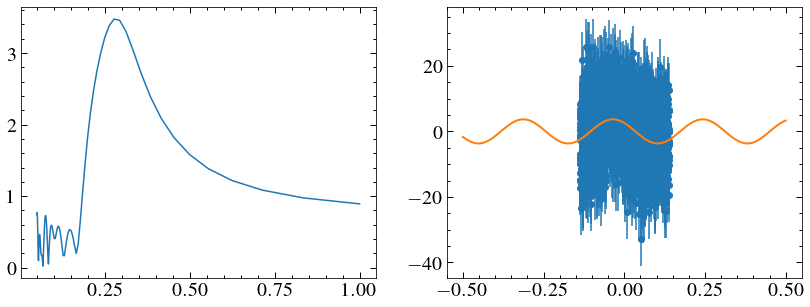

2149.519617308289
3.2954681284953047 %
0.27768912411495544 d


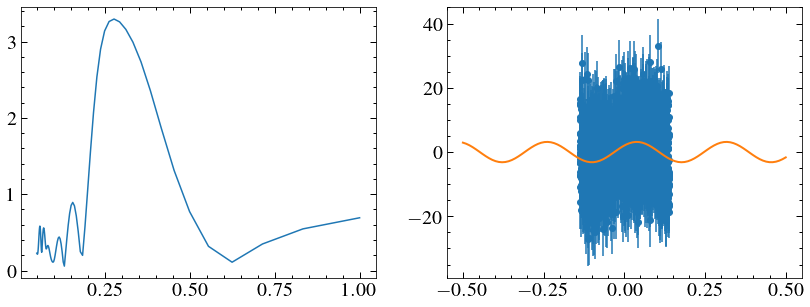

2150.019617308289
3.1519556872976953 %
0.294025672158843 d


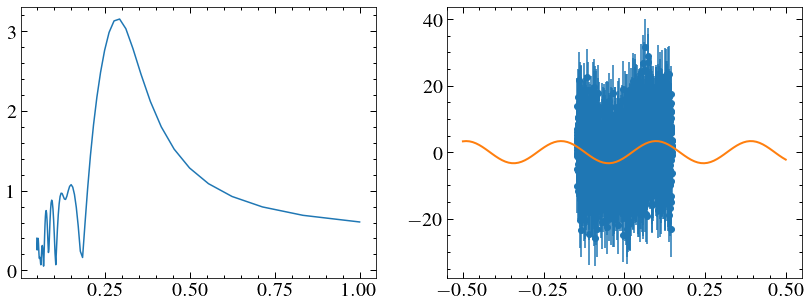

2150.519617308289
4.247977244904837 %
0.2776886847481302 d


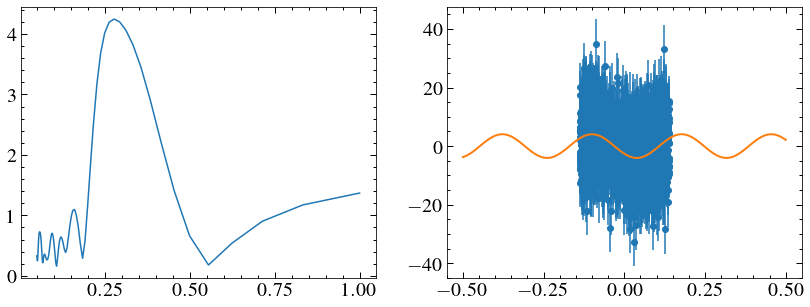

2151.019617308289
3.263192141571525 %
0.277688470017716 d


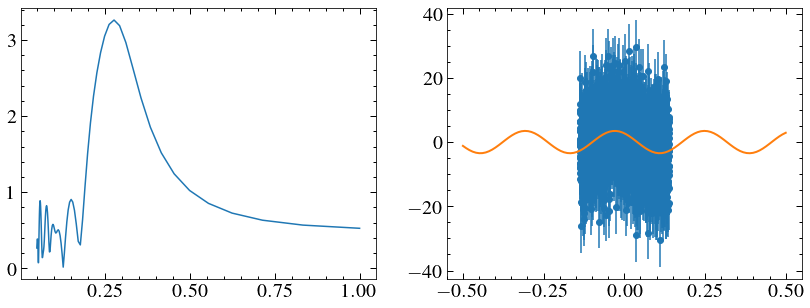

2151.519617308289
3.50470083086296 %
0.2776882580899125 d


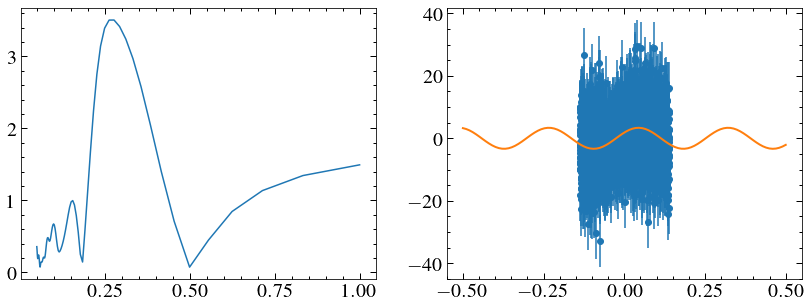

2152.019617308289
3.0566287102925562 %
0.2776880487787514 d


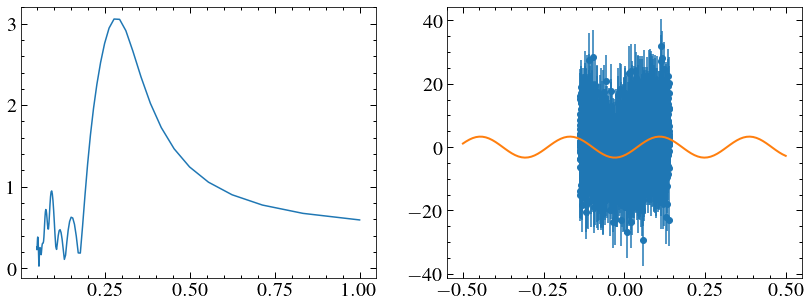

2152.519617308289
3.7689993350257733 %
0.29402457439531876 d


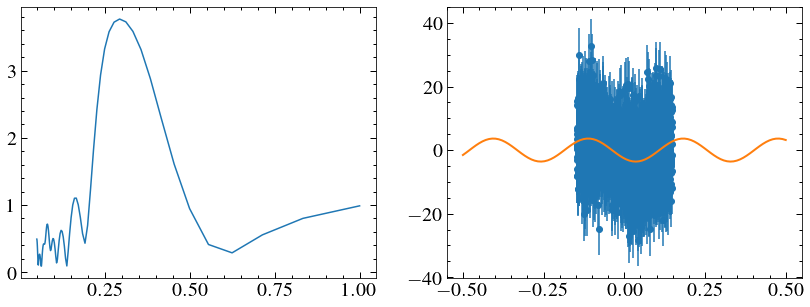

2153.019617308289
3.2807033611096483 %
0.2776876372568227 d


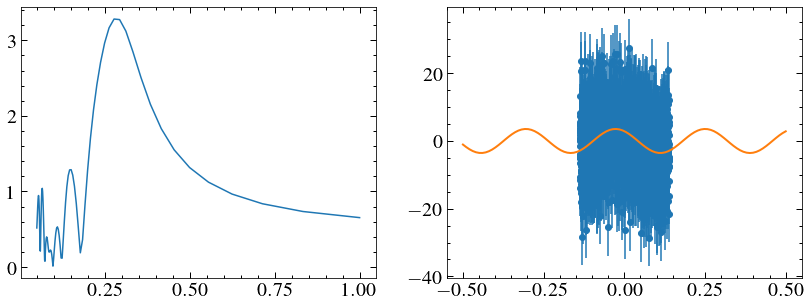

2153.519617308289
3.3610853847474993 %
0.2776874359799462 d


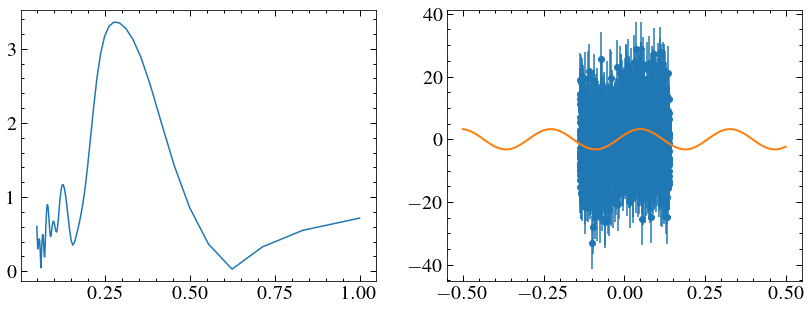

2154.019617308289
2.981674770045135 %
0.2940239500851774 d


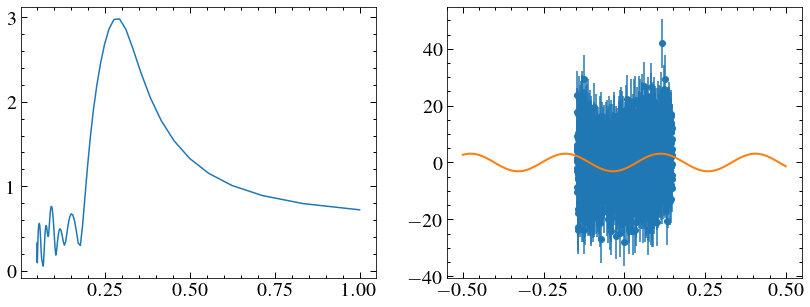

2154.519617308289
3.901780287151758 %
0.29402375203807696 d


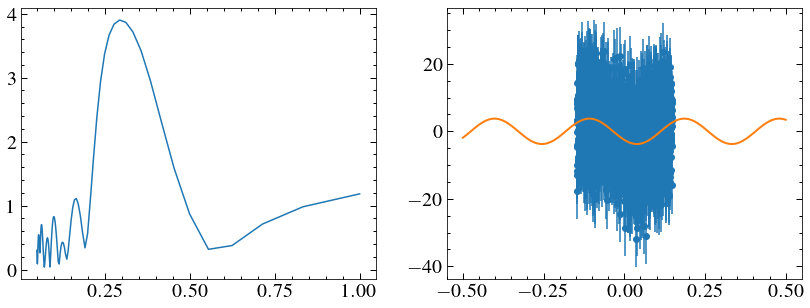

2155.019617308289
3.5775431094151395 %
0.2939274069473555 d


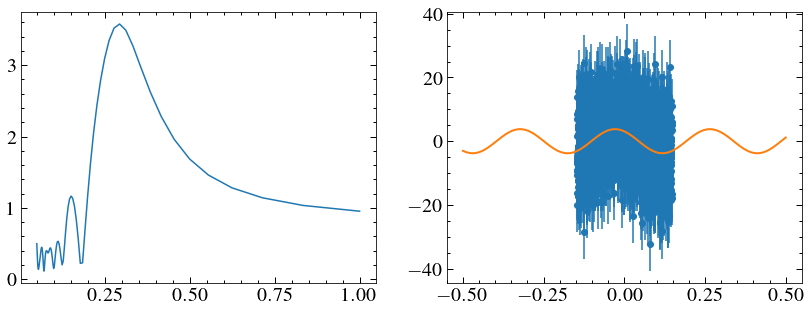

2155.519617308289
3.7754182957079627 %
0.3181697263575168 d


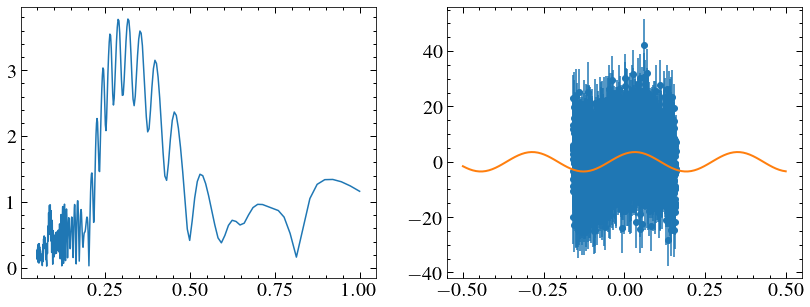

2159.019617308289
3.58441127039423 %
0.2940238958421072 d


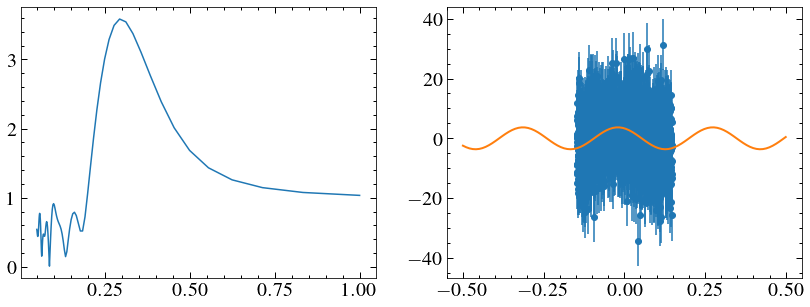

2159.519617308289
3.760750547200571 %
0.2940234355375865 d


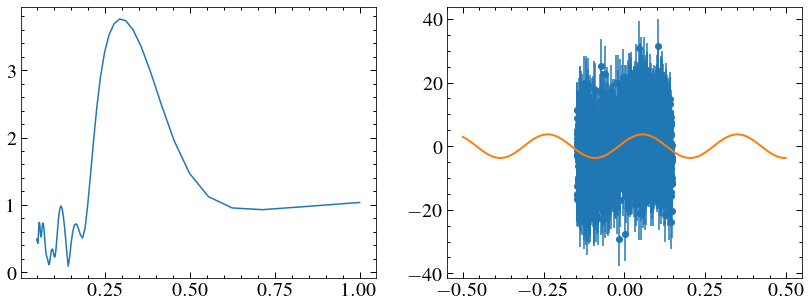

2160.019617308289
3.692441347625299 %
0.2776863579350638 d


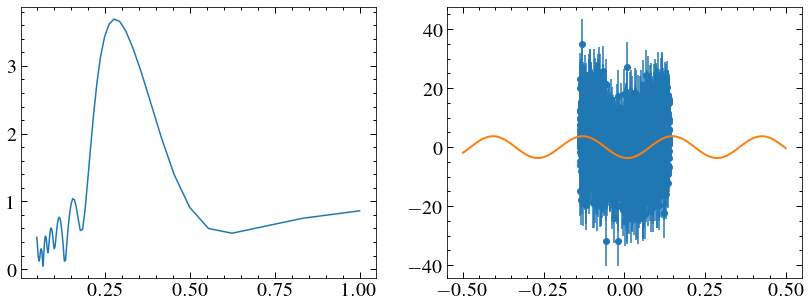

2160.519617308289
3.745449184619504 %
0.2776860206051262 d


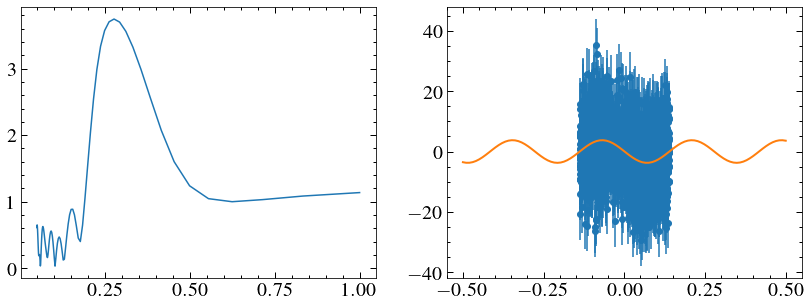

2161.019617308289
3.68880968843043 %
0.2939262174737332 d


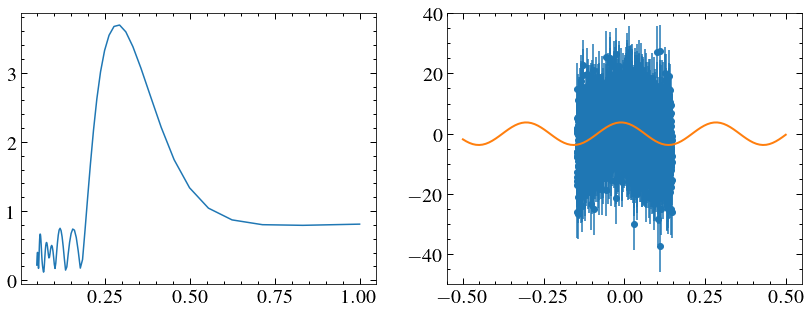

2161.519617308289
3.402415711382912 %
0.29402208072879343 d


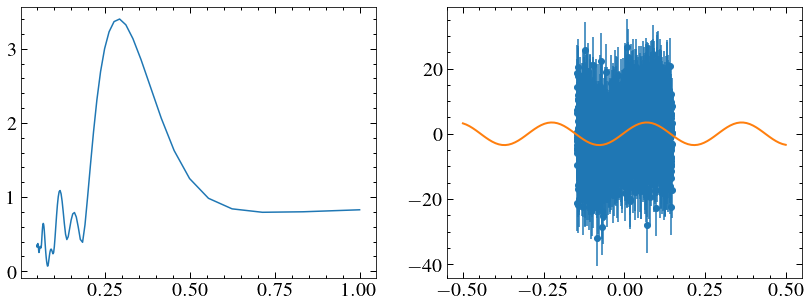

2162.019617308289
3.4035914391502775 %
0.29392564831787055 d


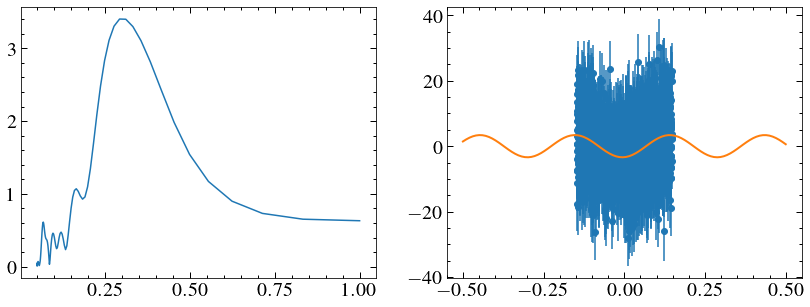

2162.519617308289
3.1869731139210993 %
0.2939253848263048 d


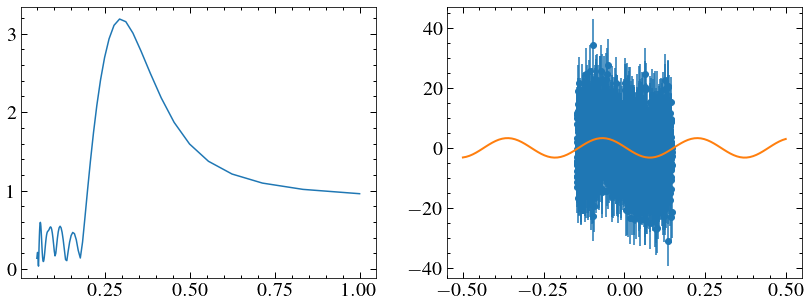

2163.019617308289
3.359857229586039 %
0.2776846645539074 d


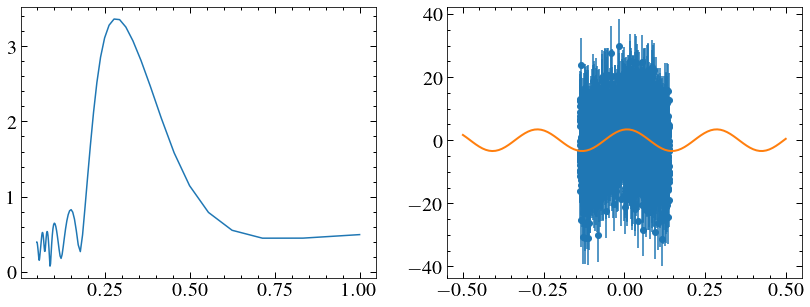

2163.519617308289
3.1163282433314072 %
0.2776844260849047 d


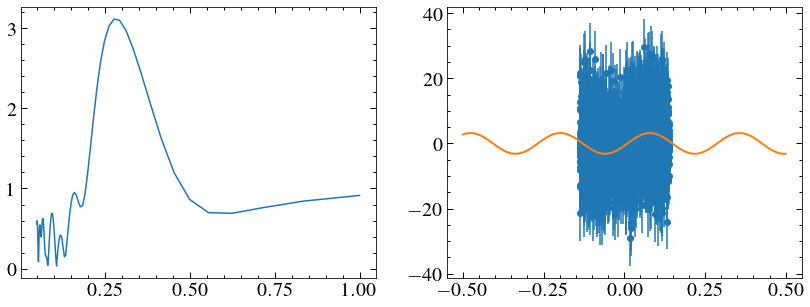

2164.019617308289
3.4311173959550034 %
0.29392464271654306 d


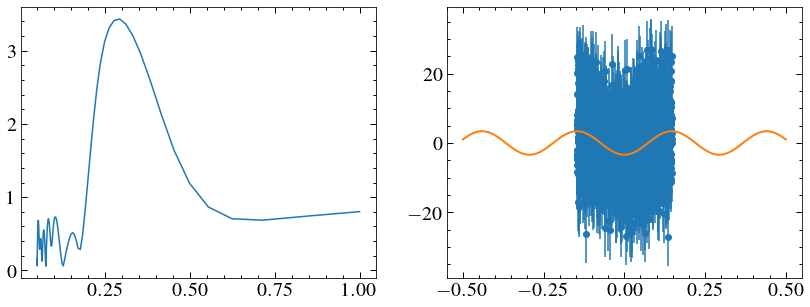

2164.519617308289
3.8420871947959396 %
0.2776839652207982 d


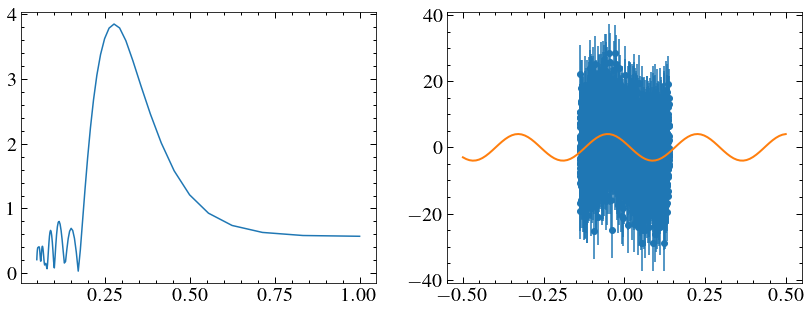

2165.019617308289
3.30953335955987 %
0.27768374095646925 d


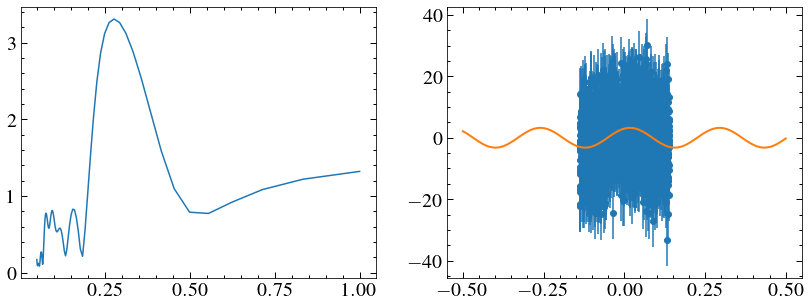

2165.519617308289
2.984736733808604 %
0.2776835200545283 d


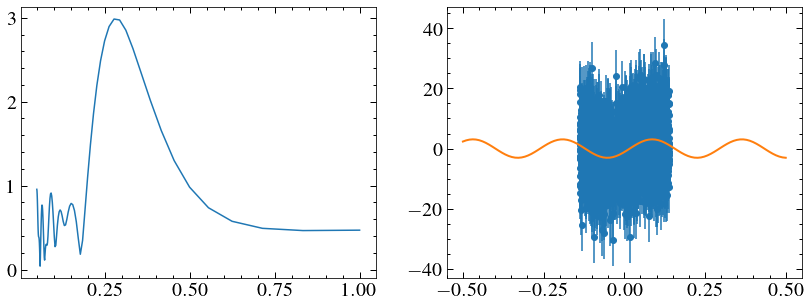

2166.019617308289
3.2667076877623287 %
0.2940198760854515 d


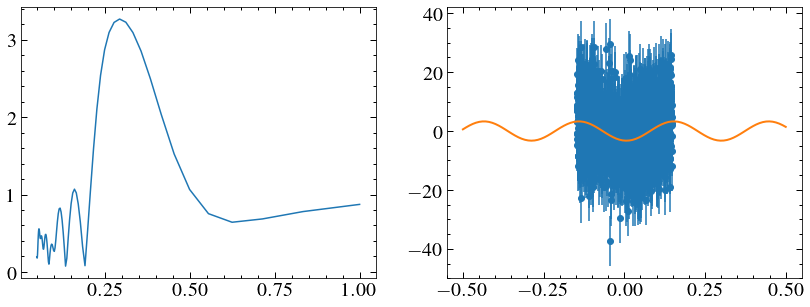

2166.519617308289
3.803582192096618 %
0.27768308628772 d


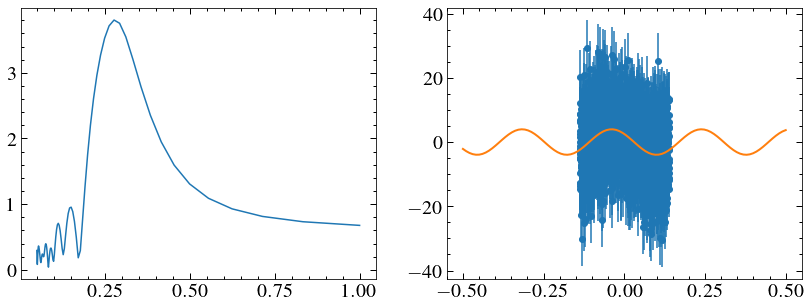

2167.019617308289
3.6391654842566883 %
0.29401943221593396 d


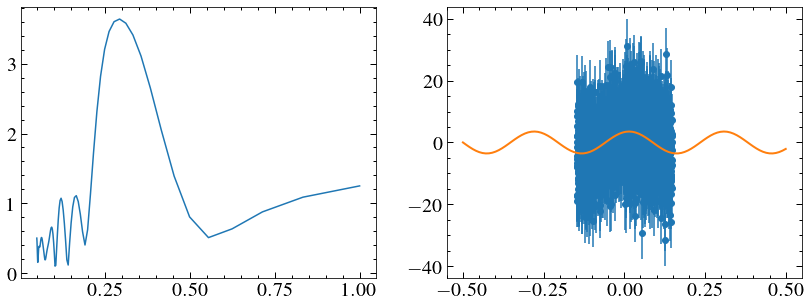

2167.519617308289
2.922792056064178 %
0.2940192138580712 d


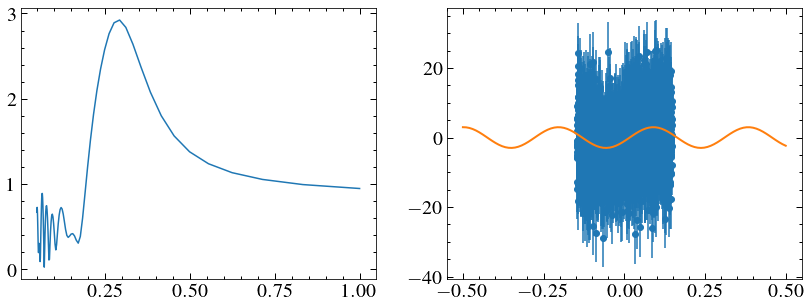

2168.019617308289
3.351301995206108 %
0.2940189982089218 d


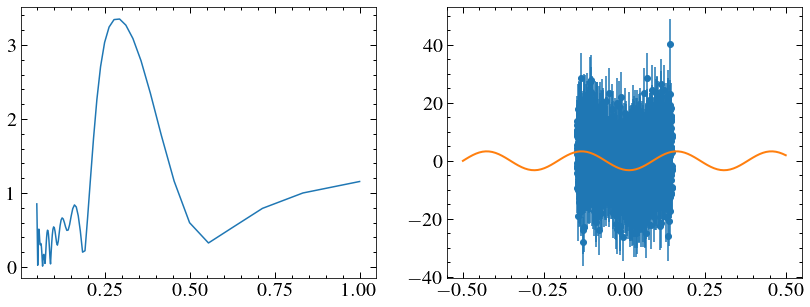

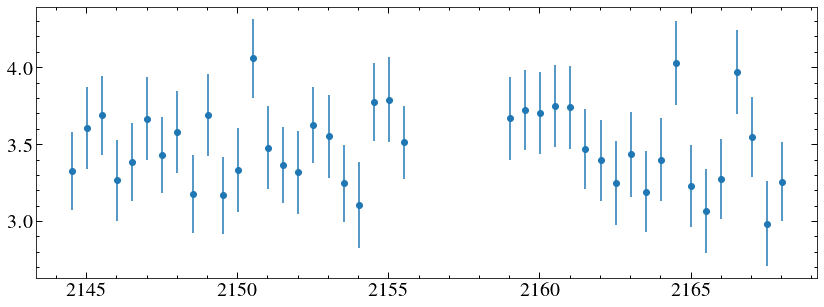

In [115]:
fitter = fitting.LevMarLSQFitter()

amplitudes = []
amp_errors = []

halfdays = np.arange(lc20n.time[0].value, lc20n.time[-1].value+0.5, 0.5)

mask = (halfdays > 2144) & (halfdays <2156)| (halfdays >2159) & (halfdays < 2169)

halfdays = halfdays[mask]

for i in range(len(halfdays)-1):
    print(halfdays[i])
    mask = (lc20n.time.value > halfdays[i]) & (lc20n.time.value < halfdays[i+1])
    lcd = lk.LightCurve(time=lc20n.time[mask], flux=lc20n.flux[mask], flux_err=lc20n.flux_err[mask] )
    pgd = lcd.to_periodogram(oversample_factor=10,minimum_period=0.05*u.day, maximum_period=1*u.day)
    print(pgd.max_power)
    print(pgd.period_at_max_power)

    plt.subplot(121)
    plt.plot(pgd.period, pgd.power)
    lcdf = lcd.fold(pgd.period_at_max_power)#.bin(0.01)
    plt.subplot(122)
   # print(lcdf.time)
    plt.errorbar(lcdf.time.value, lcdf.flux.value, yerr=lcdf.flux_err.value, marker='o', ls='none')
    fold_mod =  models.Sine1D(amplitude=pgd.max_power.value, frequency= 1/pgd.period_at_max_power.value, phase=0, fixed={'frequency':True})
    fold_fit = fitter(fold_mod, lcdf.time.value, lcdf.flux.value, weights = 1/lcdf.flux_err.value, maxiter=10000)
    fold_fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))
    fold_time = np.linspace(-0.5, 0.5, 100)
    plt.plot(fold_time, fold_fit(fold_time), c='C1', lw=2, zorder=10)
    plt.show()
    amplitudes.append(abs(fold_fit.amplitude.value))
    amp_errors.append(fold_fit_e[0])
   # lcd.scatter()
    #plt.show()
    
plt.errorbar(halfdays[:-1], amplitudes, yerr=amp_errors, marker='o', ls='none')
plt.show()

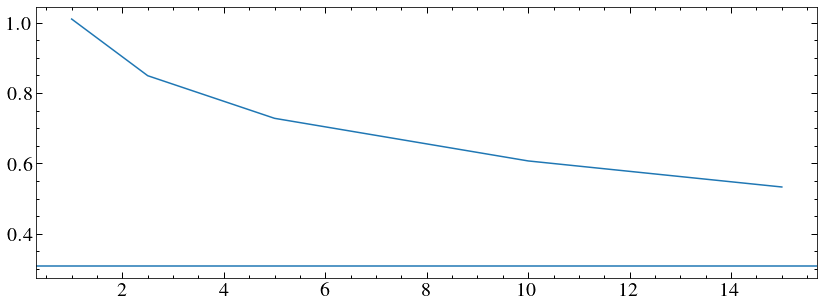

In [116]:
ad = anderson(amplitudes)
plt.plot(ad.significance_level, ad.critical_values)
plt.axhline(ad.statistic)